In [2]:
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures


In [3]:
data = pd.read_csv('../data/raw_analyst_ratings.csv')

# data = pd.read_csv('../data/raw_analyst_ratings.csv', parse_dates=['date'])

In [ ]:
# DECRPTIVE STATISTICS

# count the length of each headline
data['headline_length'] = data['headline'].apply(len)
print(data['headline_length'].describe())

# count the length of each summary
publisher_count = data['publisher'].value_counts()
print(publisher_count)


# MISSING DATA
null_date = data['date'].isnull().sum()
print(null_date)

# Convert publication date to datetime
data['date'] = pd.to_datetime(data['date'],format='ISO8601',errors='coerce',utc=True)

# Group by date and count the number of articles
daily_headlines = data.groupby(data['date'].dt.date).size()

print(daily_headlines)


count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64
publisher
Paul Quintaro                 228373
Lisa Levin                    186979
Benzinga Newsdesk             150484
Charles Gross                  96732
Monica Gerson                  82380
                               ...  
David Wenger                       1
Holly Huber - CrowdStreet          1
Ryan Smith                         1
vic@forextraininggroup.com         1
official@stockmetrix.net           1
Name: count, Length: 1034, dtype: int64
0
date
2009-02-14      1
2009-04-27      2
2009-04-29      1
2009-05-22      1
2009-05-27      6
             ... 
2020-06-07     25
2020-06-08    765
2020-06-09    803
2020-06-10    807
2020-06-11    544
Length: 3955, dtype: int64


In [ ]:
time_series_data = pd.DataFrame({'date': daily_headlines.index, 'Headlined count': daily_headlines.values})
time_series_data.set_index('date', inplace=True)
print(time_series_data)

            Headlined count
date                       
2009-02-14                1
2009-04-27                2
2009-04-29                1
2009-05-22                1
2009-05-27                6
...                     ...
2020-06-07               25
2020-06-08              765
2020-06-09              803
2020-06-10              807
2020-06-11              544

[3955 rows x 1 columns]


In [ ]:


# Trend extraction
data['Trend'] = data['headline_length'].rolling(window=4, center=True).mean()


# Trend extraction
data['Trend'] = data['headline_length'].rolling(window=4, center=True).mean()

# Detrend to get seasonal + residual
detrended = data['headline_length'] - data['Trend']

# (Optional) Extract seasonality using a simple moving average of detrended data
data['Seasonal'] = detrended.rolling(window=4, center=True).mean()

# Residuals
data['Residual'] = detrended - data['Seasonal']

# Plotting the manually extracted components
plt.figure(figsize=(14, 10))

plt.subplot(411)
plt.plot(data['headline_length'], label='Original', color='blue')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(data['Trend'], label='Trend', color='orange')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(data['Seasonal'], label='Seasonal', color='green')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(data['Residual'], label='Residual', color='red')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()




# Detrend to get seasonal + residual
detrended = data['headline_length'] - data['Trend']

# (Optional) Extract seasonality using a simple moving average of detrended data
data['Seasonal'] = detrended.rolling(window=4, center=True).mean()

# Residuals
data['Residual'] = detrended - data['Seasonal']

# Plotting the manually extracted components
plt.figure(figsize=(14, 10))

plt.subplot(411)
plt.plot(data['headline_length'], label='Original', color='blue')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(data['Trend'], label='Trend', color='orange')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(data['Seasonal'], label='Seasonal', color='green')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(data['Residual'], label='Residual', color='red')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()





NameError: name 'data' is not defined

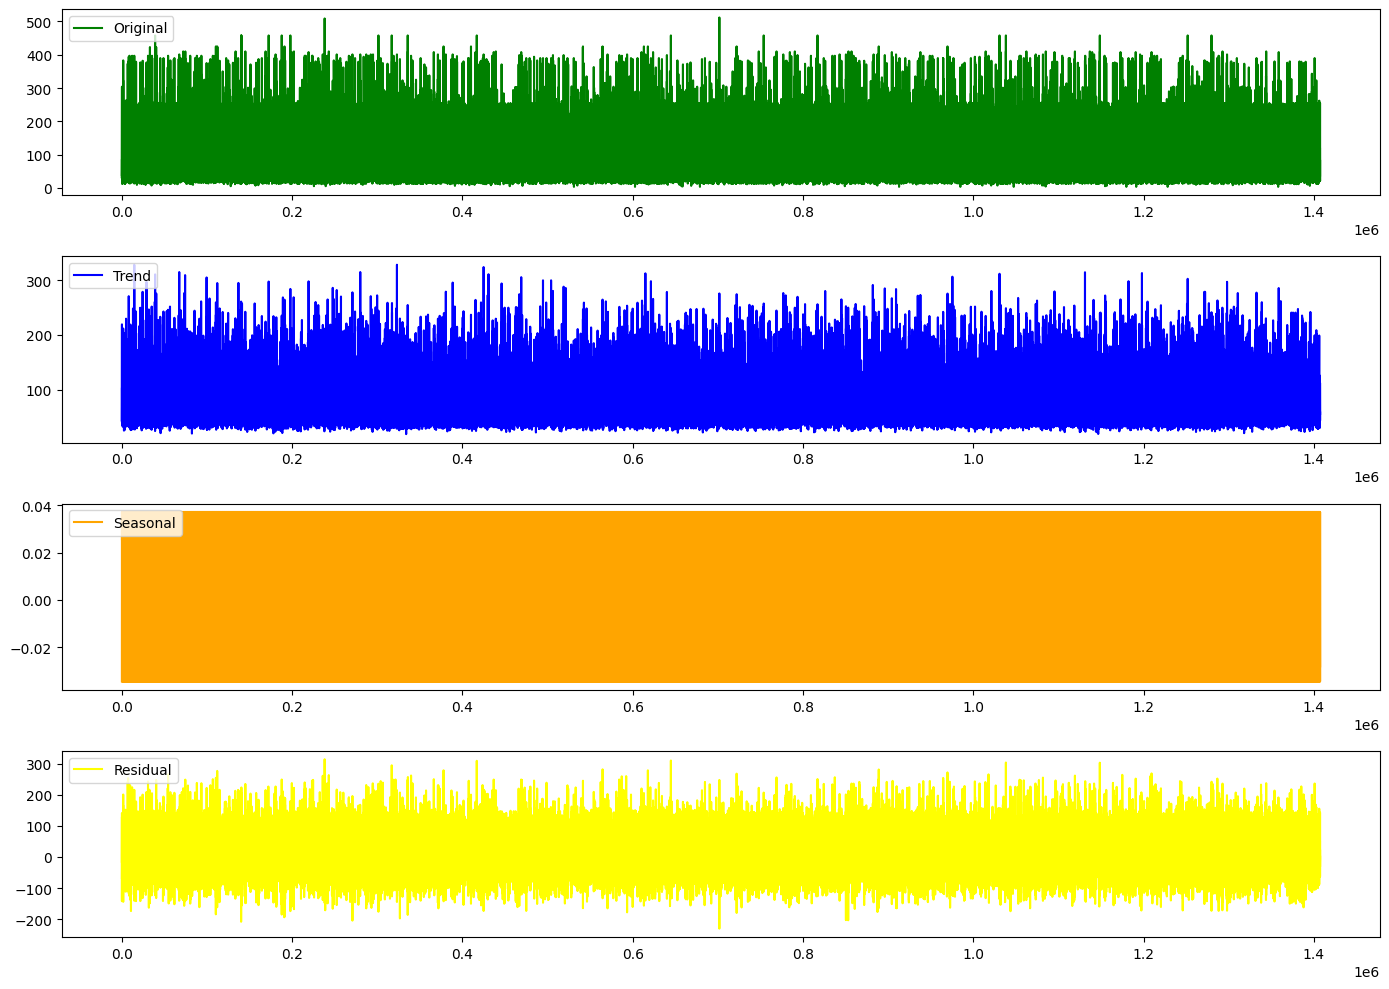

In [ ]:
decomposition = seasonal_decompose(data['headline_length'], model='additive', period=4)

# Plot the original data, trend, seasonal and residuals
plt.figure(figsize=(14, 10))

plt.subplot(411)
plt.plot(data['headline_length'], label='Original',color='green')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color='blue')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal', color='orange')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual', color='yellow')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

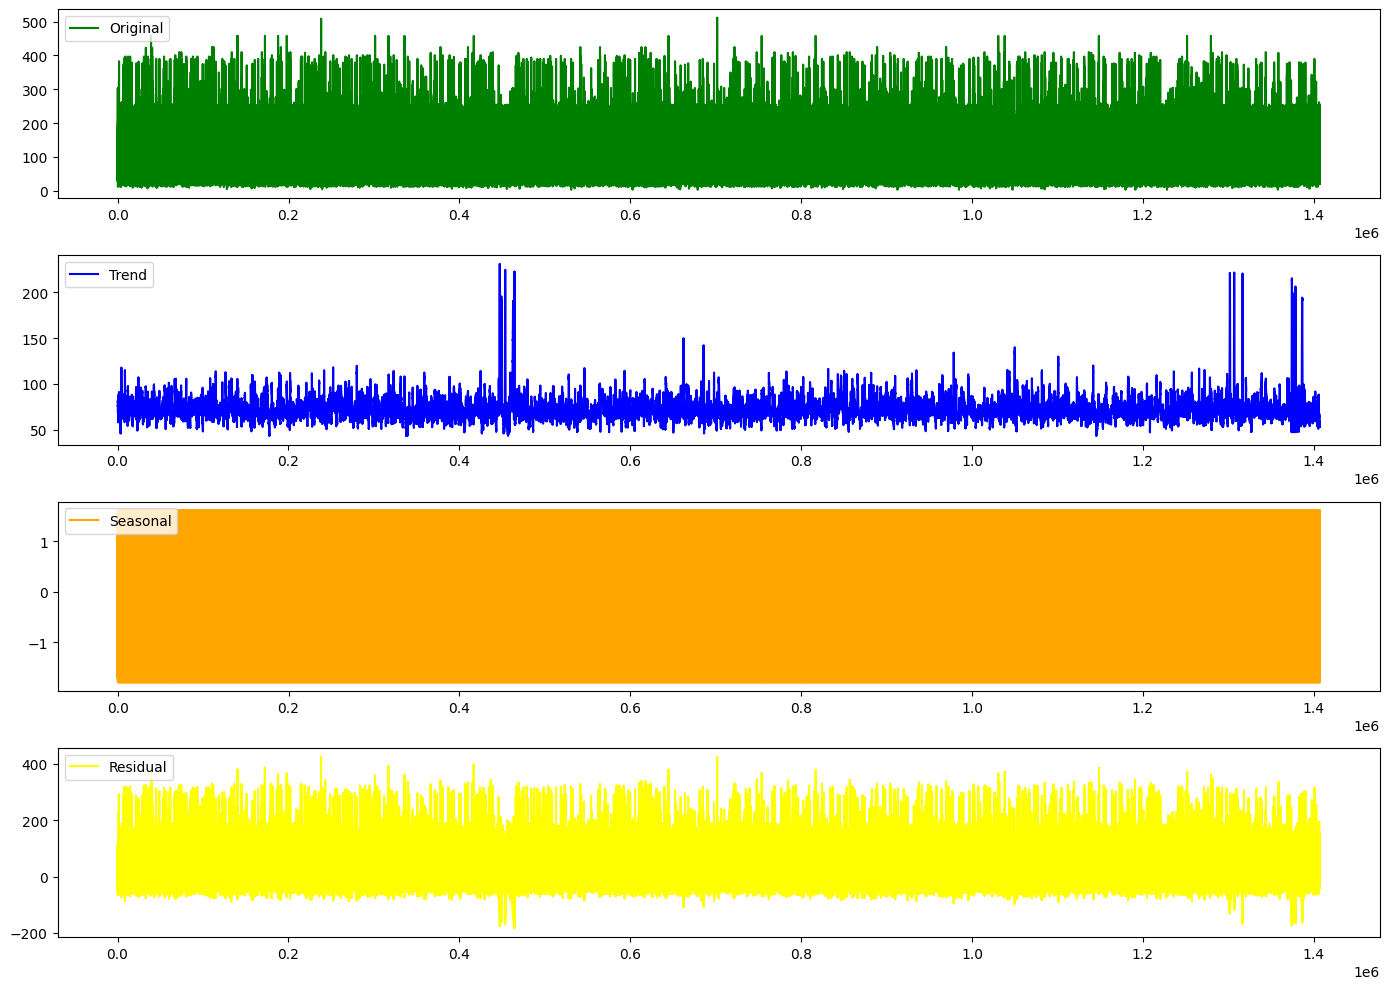

In [ ]:
decomposition = seasonal_decompose(data['headline_length'], model='additive', period=365)

# Plot the original data, trend, seasonal and residuals
plt.figure(figsize=(14, 10))

plt.subplot(411)
plt.plot(data['headline_length'], label='Original',color='green')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color='blue')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal', color='orange')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual', color='yellow')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
def get_sentiment(text):
    polarity = TextBlob(text).sentiment.polarity
    return polarity

def get_sentiment_catgory(text):
    sentiment = get_sentiment(text)
    if sentiment > 0:
        return 'positive'
    elif sentiment < 0:
        return 'negative'
    else:
        return 'neutral'
    
data['sentiment'] = data['headline'].apply(get_sentiment)
data['sentiment_category'] = data['headline'].apply(get_sentiment_catgory)



In [ ]:
data.tail()

,Unnamed: 0,headline,url,publisher,date,stock,headline_length,Trend,Seasonal,Residual,sentiment,sentiment_category
1407323,1413844,Top Narrow Based Indexes For August 29,https://www.benzinga.com/news/11/08/1888782/to...,Monica Gerson,2011-08-29 04:00:00+00:00,ZX,38,71.50,-0.9375,-32.5625,0.15,positive
1407324,1413845,Recap: Wednesday's Top Percentage Gainers and ...,https://www.benzinga.com/news/earnings/11/06/1...,Benjamin Lee,2011-06-22 04:00:00+00:00,ZX,52,59.00,-5.5625,-1.4375,0.15,positive
1407325,1413846,UPDATE: Oppenheimer Color on China Zenix Auto ...,https://www.benzinga.com/analyst-ratings/analy...,BenzingaStaffL,2011-06-21 04:00:00+00:00,ZX,56,50.00,-10.3125,16.3125,0.00,neutral
1407326,1413847,Oppenheimer Initiates China Zenix At Outperfor...,https://www.benzinga.com/analyst-ratings/price...,Joe Young,2011-06-21 04:00:00+00:00,ZX,54,60.75,NaN,NaN,0.00,neutral
1407327,1413848,China Zenix Auto International Opens For Tradi...,https://www.benzinga.com/news/ipos/11/05/10789...,Allie Wickman,2011-05-12 04:00:00+00:00,ZX,81,NaN,NaN,NaN,0.00,neutral


In [ ]:
# Keyword Extraction
data = data.head(100)

vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(data['headline'])
df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
keyword_counts = df.sum(axis=0).sort_values(ascending=False)
print("Most common keywords:")
print(keyword_counts.head(10))

# Phrase Extraction
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
X = vectorizer.fit_transform(data['headline'])
df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
phrase_counts = df.sum(axis=0).sort_values(ascending=False)
print("\nMost common phrases:")
print(phrase_counts.head(10))

# Topic Modeling
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(data['headline'])
lda = LatentDirichletAllocation(n_components=2, random_state=0)
lda.fit(X)
feature_names = vectorizer.get_feature_names_out()
print("\nExtracted topics:")
for idx, topic in enumerate(lda.components_):
    print(f"Topic {idx}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[-10:]]))

Most common keywords:
agilent         43
technologies    27
stocks          25
shares          24
trading         23
price           20
week            19
target          19
companies       17
hit             16
dtype: int64

Most common phrases:
agilent technologies    27
price target            19
52 week                 16
stocks hit              16
hit 52                  16
companies trading       15
week highs              14
trading higher          13
healthcare companies    12
shares healthcare       12
dtype: int64

Extracted topics:
Topic 0:
moving session 2020 thursday friday highs week 52 hit stocks
Topic 1:
higher companies neutral trading shares maintains target price technologies agilent


In [ ]:
nltk.download('punkt_tab')

# Tokenize and clean the headlines
stop_words = set(stopwords.words('english'))
cleaned_headlines = []

for headline in data['headline']:
    words = word_tokenize(headline.lower())
    words = [word for word in words if word.isalpha() and word not in stop_words]
    cleaned_headlines.append(words)

# Flatten the list of words
all_words = [word for headline in cleaned_headlines for word in headline]

# Frequency distribution
freq_dist = FreqDist(all_words)

# Most common words
common_words = freq_dist.most_common(10)

# Find bigrams
bigram_finder = BigramCollocationFinder.from_words(all_words)
bigrams = bigram_finder.nbest(BigramAssocMeasures.likelihood_ratio, 10)

common_words, bigrams

[nltk_data] Downloading package punkt_tab to /home/abrham/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


([('agilent', 42),
  ('technologies', 27),
  ('stocks', 25),
  ('shares', 24),
  ('trading', 23),
  ('price', 20),
  ('target', 19),
  ('several', 18),
  ('companies', 17),
  ('hit', 16)],
 [('agilent', 'technologies'),
  ('price', 'target'),
  ('hit', 'highs'),
  ('shares', 'several'),
  ('stocks', 'hit'),
  ('companies', 'trading'),
  ('healthcare', 'companies'),
  ('several', 'healthcare'),
  ('trading', 'higher'),
  ('trading', 'lower')])

In [ ]:
# Count the number of articles per publisher
publisher_counts = data['publisher'].value_counts()

# Display the top publishers
print(publisher_counts.head(10))

publisher
Benzinga Newsdesk          41
Lisa Levin                 28
Vick Meyer                 11
vishwanath@benzinga.com     5
Wayne Duggan                3
Benzinga Insights           2
Tyree Gorges                2
Benzinga_Newsdesk           2
luke@benzinga.com           2
Shivdeep Dhaliwal           1
Name: count, dtype: int64


In [ ]:
category_counts = data.groupby('publisher')['sentiment_category'].value_counts(normalize=True).unstack()

# Display the distribution of categories for the top publishers
top_publishers = publisher_counts.head(10).index
print(category_counts.loc[top_publishers])

sentiment_category       negative   neutral  positive
publisher                                            
Benzinga Newsdesk        0.097561  0.487805  0.414634
Lisa Levin                    NaN  0.821429  0.178571
Vick Meyer                    NaN  1.000000       NaN
vishwanath@benzinga.com       NaN  1.000000       NaN
Wayne Duggan                  NaN  0.666667  0.333333
Benzinga Insights             NaN  1.000000       NaN
Tyree Gorges                  NaN  1.000000       NaN
Benzinga_Newsdesk             NaN  1.000000       NaN
luke@benzinga.com        0.500000       NaN  0.500000
Shivdeep Dhaliwal             NaN  1.000000       NaN


In [ ]:
# Extract domain from email addresses
data['domain'] = data['publisher'].str.extract(r'@([\w\.-]+)')

# Count the number of articles per domain
domain_counts = data['domain'].value_counts()

# Display the top contributing domains
print(domain_counts.head(10))


domain
benzinga.com    7
Name: count, dtype: int64
